In [1]:
from matplotlib import pyplot as plt
from tabulate import tabulate
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

plt.style.use('dark_background')
sns.set_palette("Set1")

In [2]:
tr_f_df = pd.read_csv(filepath_or_buffer='./data/train_fea.csv')
cv_f_df = pd.read_csv(filepath_or_buffer='./data/cv_fea.csv')
te_f_df = pd.read_csv(filepath_or_buffer='./data/test_fea.csv')

In [3]:
fea_cols = list(tr_f_df.columns)
target = fea_cols.pop()
labels = cv_f_df['class'].unique()

In [4]:
X_train = tr_f_df[fea_cols].values
y_train = tr_f_df[target].values

X_cv = cv_f_df[fea_cols].values
y_cv = cv_f_df[target].values

X_test = te_f_df[fea_cols].values
y_test = te_f_df[target].values

In [5]:
def plot_heatmap(matrix, title, labels):
    sns.heatmap(data=matrix, annot=True, fmt='.2f', linewidths=0.1,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel(xlabel='Predicted Class')
    plt.ylabel(ylabel='Actual Class')
    plt.title(label=title, fontsize=10)

In [6]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    pmat = cmat / cmat.sum(axis=0)
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    rmat = ((cmat.T) / (cmat.sum(axis=1).T)).T
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    plt.figure(figsize=(15, 3))
    plt.subplot(131)
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plt.subplot(132)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plt.subplot(133)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)
    plt.show()

In [7]:
def reporter(clf, X, y, title, labels, best=None):
    pred = clf.predict_proba(X=X)
    
    loss = log_loss(y_true=y, y_pred=pred)
    loss = np.round(a=loss, decimals=3)
    
    cm_pred = clf.predict(X=X)
    
    print(title)
    if best is None:
        print("Logloss: {}".format(loss))
    else:
        print("Logloss: {}".format(loss))
        print("Best parameters: {}".format(best))
    
    plot_confusion_matrix(y_true=y, y_pred=cm_pred, labels=labels)
    
    print(classification_report(y_true=y, y_pred=cm_pred))
    
    return loss

In [8]:
def tuner(clf, dist, X, y):
    rs_clf = RandomizedSearchCV(estimator=clf, random_state=0, n_jobs=-1,
                                param_distributions=dist)
    search = rs_clf.fit(X=X, y=y)
    return search.best_params_

In [9]:
def get_model_path(model_name):
    if os.path.isdir('./data/model_dumps'):
        pass
    else:
        os.mkdir(path='./data/model_dumps')
    
    model_path = os.path.join('./data/model_dumps', model_name)
    return model_path

In [10]:
def dummy_classifier(X_train,
                     y_train,
                     X_cv,
                     y_cv,
                     X_test,
                     y_test,
                     model_name,
                     labels=labels):
    model_path = get_model_path(model_name=model_name)
    
    if not os.path.isfile(path=model_path):
        clf = DummyClassifier(strategy='uniform')
        clf.fit(X=X_train, y=y_train)
        
        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=clf, file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    tr_loss = reporter(clf=clf, X=X_train, y=y_train,
                       title='Train', labels=labels)
    cv_loss = reporter(clf=clf, X=X_cv, y=y_cv,
                       title='Cross Validation', labels=labels)
    te_loss = reporter(clf=clf, X=X_test, y=y_test,
                       title='Test', labels=labels)
    
    return tr_loss, cv_loss, te_loss

Model saved into the disk.

Train
Logloss: 0.693
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


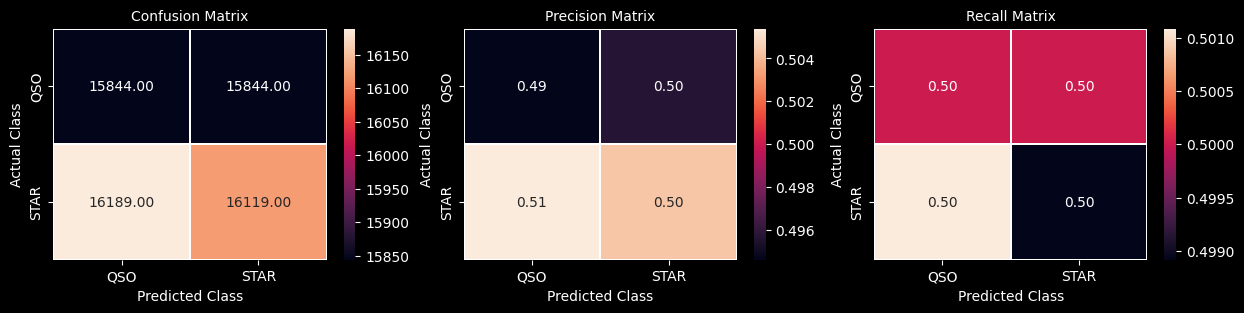

              precision    recall  f1-score   support

         QSO       0.49      0.50      0.50     31688
        STAR       0.50      0.50      0.50     32308

    accuracy                           0.50     63996
   macro avg       0.50      0.50      0.50     63996
weighted avg       0.50      0.50      0.50     63996

Cross Validation
Logloss: 0.693
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


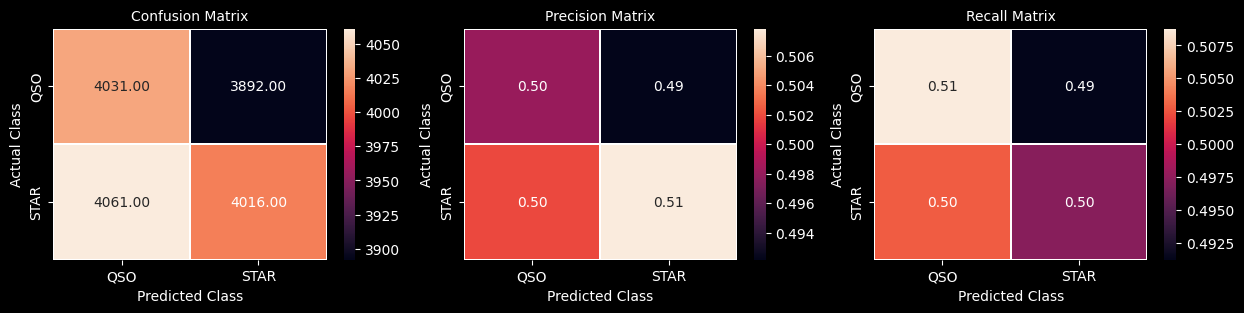

              precision    recall  f1-score   support

         QSO       0.50      0.51      0.50      7923
        STAR       0.51      0.50      0.50      8077

    accuracy                           0.50     16000
   macro avg       0.50      0.50      0.50     16000
weighted avg       0.50      0.50      0.50     16000

Test
Logloss: 0.693
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


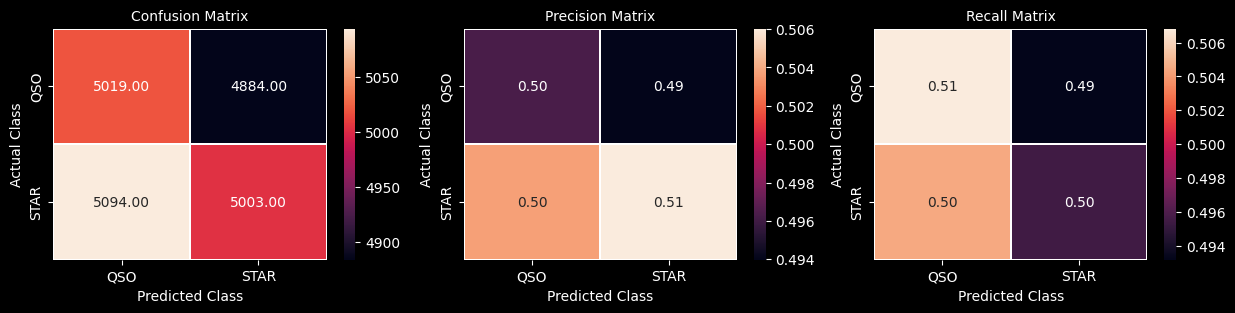

              precision    recall  f1-score   support

         QSO       0.50      0.51      0.50      9903
        STAR       0.51      0.50      0.50     10097

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [11]:
model_name = 'model_dummy_classifier.pkl'

(dummy_tr_loss,
 dummy_cv_loss,
 dummy_te_loss) = dummy_classifier(X_train=X_train,
                                   y_train=y_train,
                                   X_cv=X_cv,
                                   y_cv=y_cv,
                                   X_test=X_test,
                                   y_test=y_test,
                                   model_name=model_name)

In [12]:
def logistic_regresson(X_train,
                       y_train,
                       X_cv,
                       y_cv,
                       X_test,
                       y_test,
                       dist,
                       model_name,
                       labels=labels):
    model_path = get_model_path(model_name=model_name)

    if not os.path.isfile(path=model_path):
        clf = LogisticRegression(n_jobs=-1, random_state=42, max_iter=1000, 
                                 class_weight='balanced')

        best = tuner(clf=clf, dist=dist, X=X_train, y=y_train)

        clf = LogisticRegression(n_jobs=-1, max_iter=1000, C=best['C'],
                                 random_state=42, penalty=best['penalty'],
                                 class_weight='balanced')
        clf.fit(X=X_train, y=y_train)

        sig_clf = CalibratedClassifierCV(base_estimator=clf)
        sig_clf.fit(X=X_train, y=y_train)

        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=(clf, sig_clf, best), file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf, sig_clf, best = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    tr_loss = reporter(clf=sig_clf, X=X_train, y=y_train,
                       title='Train', best=best, labels=labels)
    cv_loss = reporter(clf=sig_clf, X=X_cv, y=y_cv,
                       title='Cross Validation', best=best, labels=labels)
    te_loss = reporter(clf=sig_clf, X=X_test, y=y_test,
                       title='Test', best=best, labels=labels)
    
    return best, tr_loss, cv_loss, te_loss

C:\Users\Hitu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Hitu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hitu\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Hitu

Model saved into the disk.

Train
Logloss: 0.423
Best parameters: {'penalty': 'l2', 'C': 10}
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


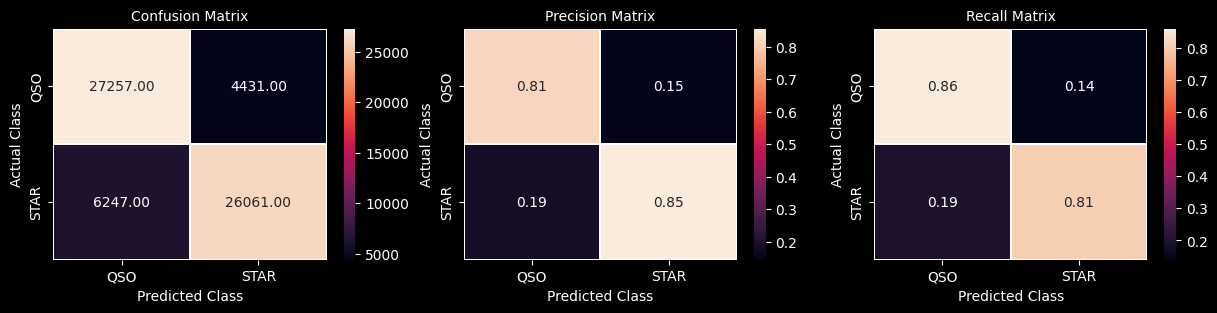

              precision    recall  f1-score   support

         QSO       0.81      0.86      0.84     31688
        STAR       0.85      0.81      0.83     32308

    accuracy                           0.83     63996
   macro avg       0.83      0.83      0.83     63996
weighted avg       0.83      0.83      0.83     63996

Cross Validation
Logloss: 0.422
Best parameters: {'penalty': 'l2', 'C': 10}
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


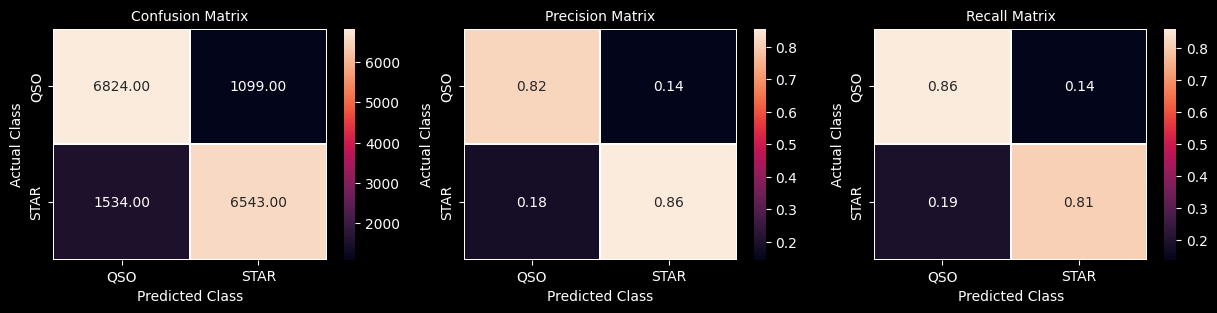

              precision    recall  f1-score   support

         QSO       0.82      0.86      0.84      7923
        STAR       0.86      0.81      0.83      8077

    accuracy                           0.84     16000
   macro avg       0.84      0.84      0.84     16000
weighted avg       0.84      0.84      0.84     16000

Test
Logloss: 0.431
Best parameters: {'penalty': 'l2', 'C': 10}
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


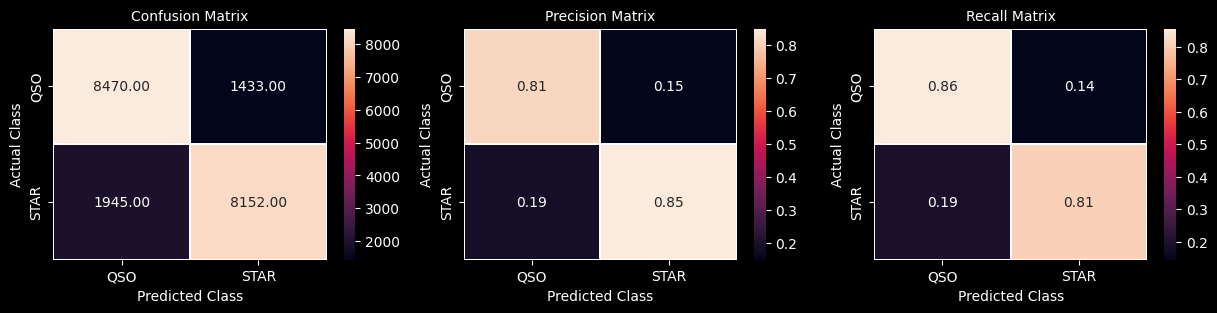

              precision    recall  f1-score   support

         QSO       0.81      0.86      0.83      9903
        STAR       0.85      0.81      0.83     10097

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



In [13]:
model_name = 'model_logistic_regression.pkl'

dist = dict(C=[10 ** x for x in range(-4, 3)], penalty=['l2', 'l1'])

(logreg_best,
 logreg_tr_loss,
 logreg_cv_loss,
 logreg_te_loss) = logistic_regresson(X_train=X_train,
                                      y_train=y_train,
                                      X_cv=X_cv,
                                      y_cv=y_cv,
                                      X_test=X_test,
                                      y_test=y_test,
                                      dist=dist,
                                      model_name=model_name)

In [14]:
def k_neighbors_classifier(X_train,
                           y_train,
                           X_cv,
                           y_cv,
                           X_test,
                           y_test,
                           dist,
                           model_name,
                           labels=labels):
    model_path = get_model_path(model_name=model_name)

    if not os.path.isfile(path=model_path):
        clf = KNeighborsClassifier(n_jobs=-1)

        best = tuner(clf=clf, dist=dist, X=X_train, y=y_train)

        clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=best['n_neighbors'])
        clf.fit(X=X_train, y=y_train)

        sig_clf = CalibratedClassifierCV(base_estimator=clf)
        sig_clf.fit(X=X_train, y=y_train)

        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=(clf, sig_clf, best), file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf, sig_clf, best = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    tr_loss = reporter(clf=sig_clf, X=X_train, y=y_train,
                       title='Train', best=best, labels=labels)
    cv_loss = reporter(clf=sig_clf, X=X_cv, y=y_cv,
                       title='Cross Validation', best=best, labels=labels)
    te_loss = reporter(clf=sig_clf, X=X_test, y=y_test,
                       title='Test', best=best, labels=labels)
    
    return best, tr_loss, cv_loss, te_loss

C:\Users\Hitu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Hitu\AppData\Roaming\Python\Python311\site-packages\sklearn\calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model saved into the disk.

Train
Logloss: 0.217
Best parameters: {'n_neighbors': 11}
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


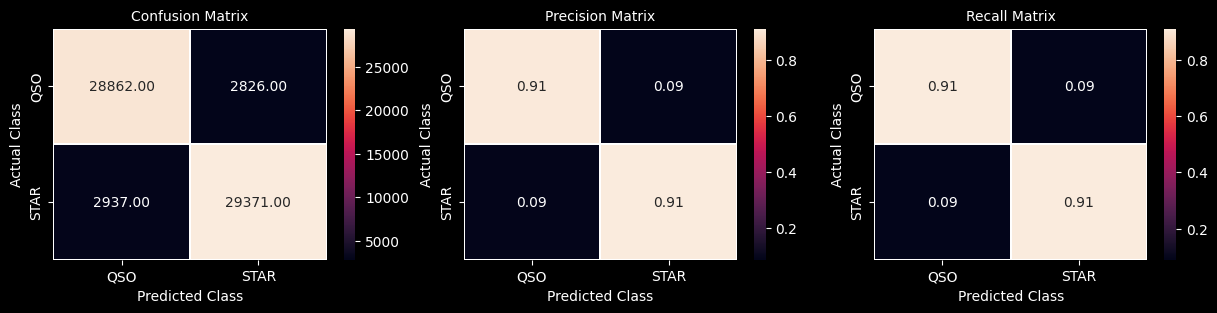

              precision    recall  f1-score   support

         QSO       0.91      0.91      0.91     31688
        STAR       0.91      0.91      0.91     32308

    accuracy                           0.91     63996
   macro avg       0.91      0.91      0.91     63996
weighted avg       0.91      0.91      0.91     63996

Cross Validation
Logloss: 0.249
Best parameters: {'n_neighbors': 11}
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


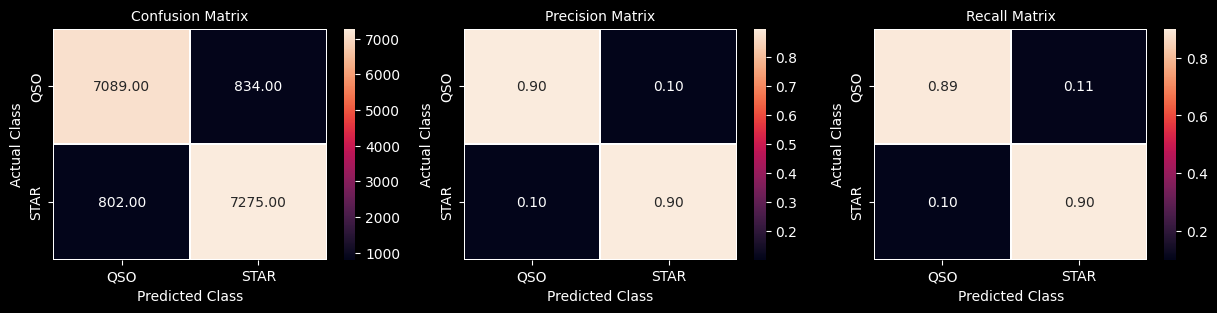

              precision    recall  f1-score   support

         QSO       0.90      0.89      0.90      7923
        STAR       0.90      0.90      0.90      8077

    accuracy                           0.90     16000
   macro avg       0.90      0.90      0.90     16000
weighted avg       0.90      0.90      0.90     16000

Test
Logloss: 0.25
Best parameters: {'n_neighbors': 11}
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


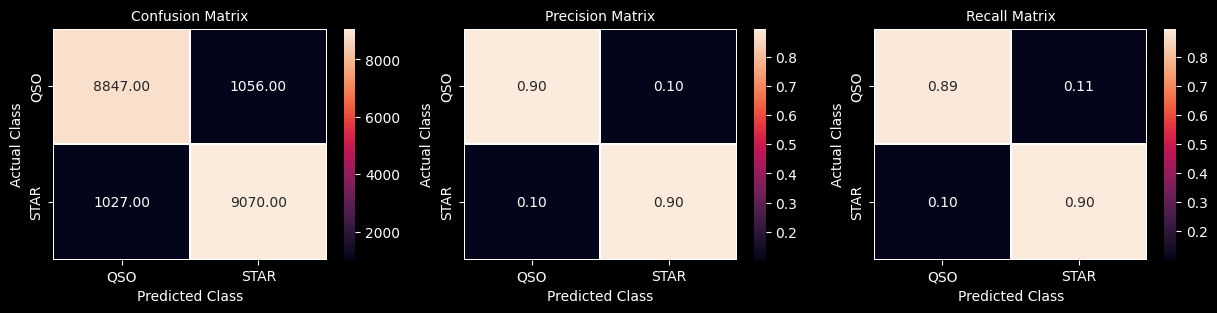

              precision    recall  f1-score   support

         QSO       0.90      0.89      0.89      9903
        STAR       0.90      0.90      0.90     10097

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



In [15]:

model_name = 'model_k_neighbors_classifier.pkl'

dist = dict(n_neighbors=[3, 5, 11, 15, 21, 31, 41, 51, 99])

(knn_best,
 knn_tr_loss,
 knn_cv_loss,
 knn_te_loss) = k_neighbors_classifier(X_train=X_train,
                                       y_train=y_train,
                                       X_cv=X_cv,
                                       y_cv=y_cv,
                                       X_test=X_test,
                                       y_test=y_test,
                                       dist=dist,
                                       model_name=model_name)

In [16]:
def feature_importance_plot(data, x, y, title):
    bars = sns.barplot(data=data, x=x, y=y)
    for b in bars.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = np.round(b.get_height(), 3)
        bars.annotate(text=format(y),
                      xy=(x, y), ha='center', va='center', size=8, 
                      xytext=(0, 6), textcoords='offset points')
    plt.title(label=title)

In [17]:
# do other feature importance stuff
fi_cols = ['g-r', 'i-z', 'u-r', 'i-r', 'z-r', 'g']

In [18]:
fi_tr_data = tr_f_df[fi_cols]
fi_cv_data = cv_f_df[fi_cols]
fi_te_data = te_f_df[fi_cols]

In [19]:

def export_data(data, target_arr, filename):
    if os.path.isdir('./data/fi_data'):
        pass
    else:
        os.mkdir(path='./data/fi_data')
    
    data['class'] = target_arr
    data.to_csv(path_or_buf=os.path.join('./data/fi_data', filename), index=None)
    print("The data is exported to '{}'.".format(filename))

In [20]:
export_data(data=fi_tr_data, target_arr=y_train, filename='fi_tr_data.csv')
export_data(data=fi_cv_data, target_arr=y_cv, filename='fi_cv_data.csv')
export_data(data=fi_te_data, target_arr=y_test, filename='fi_te_data.csv')

C:\Users\Hitu\AppData\Local\Temp\ipykernel_48448\2223666122.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = target_arr


The data is exported to 'fi_tr_data.csv'.
The data is exported to 'fi_cv_data.csv'.
The data is exported to 'fi_te_data.csv'.


C:\Users\Hitu\AppData\Local\Temp\ipykernel_48448\2223666122.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = target_arr
C:\Users\Hitu\AppData\Local\Temp\ipykernel_48448\2223666122.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = target_arr


In [21]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(estimator=model,
                             X=X, y=y, scoring='accuracy',
                             cv=cv, n_jobs=-1,
                             error_score='raise')
    return scores

In [22]:
def stacking_classifier(X_train,
                        y_train,
                        X_cv,
                        y_cv,
                        X_test,
                        y_test,
                        models,
                        model_name,
                        labels=labels):
    model_path = get_model_path(model_name=model_name)
    
    if not os.path.isfile(path=model_path):
        clf = StackingClassifier(estimators=models)
        clf.fit(X=X_train, y=y_train)

        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=clf, file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    tr_loss = reporter(clf=clf, X=X_train, y=y_train,
                       title='Train', labels=labels)
    cv_loss = reporter(clf=clf, X=X_cv, y=y_cv,
                       title='Cross Validation', labels=labels)
    te_loss = reporter(clf=clf, X=X_test, y=y_test,
                       title='Test', labels=labels)
    
    return tr_loss, cv_loss, te_loss

Model saved into the disk.

Train
Logloss: 0.214
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


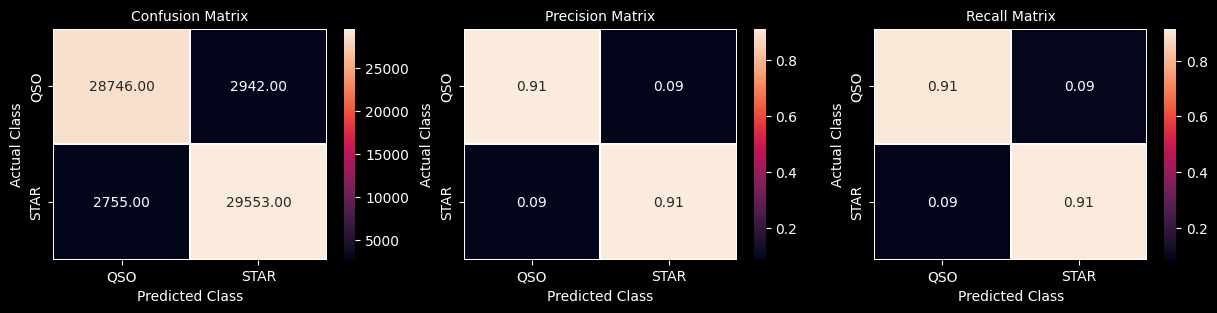

              precision    recall  f1-score   support

         QSO       0.91      0.91      0.91     31688
        STAR       0.91      0.91      0.91     32308

    accuracy                           0.91     63996
   macro avg       0.91      0.91      0.91     63996
weighted avg       0.91      0.91      0.91     63996

Cross Validation
Logloss: 0.253
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


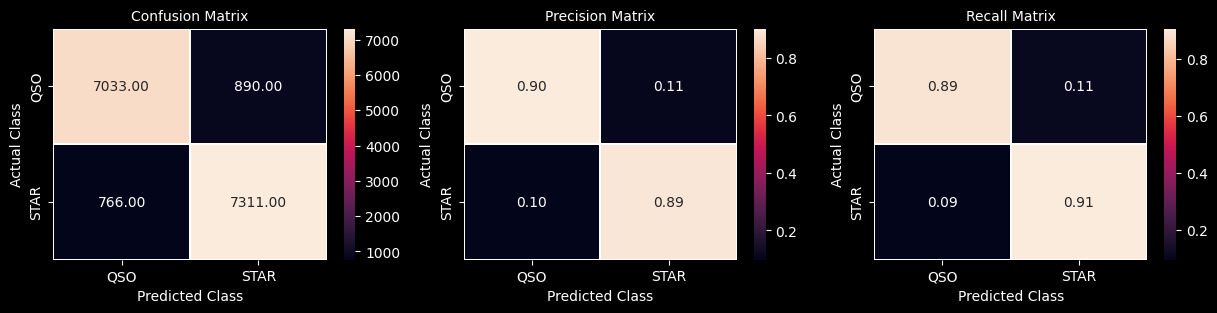

              precision    recall  f1-score   support

         QSO       0.90      0.89      0.89      7923
        STAR       0.89      0.91      0.90      8077

    accuracy                           0.90     16000
   macro avg       0.90      0.90      0.90     16000
weighted avg       0.90      0.90      0.90     16000

Test
Logloss: 0.256
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


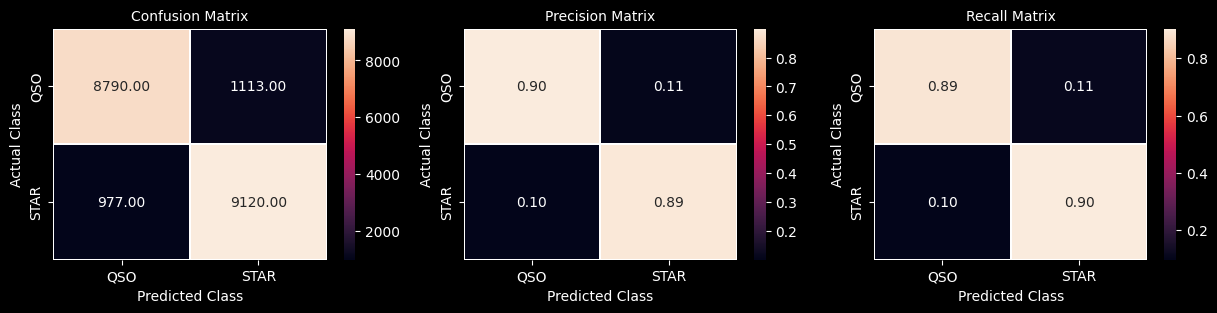

              precision    recall  f1-score   support

         QSO       0.90      0.89      0.89      9903
        STAR       0.89      0.90      0.90     10097

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



In [23]:
model_name = 'model_stacking_classifier.pkl'

LR = LogisticRegression(penalty=logreg_best['penalty'],
                        C=logreg_best['C'],
                        class_weight='balanced',
                        random_state=42,
                        n_jobs=-1, max_iter=1000)


KNN = KNeighborsClassifier(n_neighbors=knn_best['n_neighbors'], n_jobs=-1)

models = [('LR', LR), ('KNN', KNN)]

(stack_tr_loss,
 stack_cv_loss,
 stack_te_loss) = stacking_classifier(X_train=X_train,
                                      y_train=y_train,
                                      X_cv=X_cv,
                                      y_cv=y_cv,
                                      X_test=X_test,
                                      y_test=y_test,
                                      models=models,
                                      model_name=model_name)

+----+---------------------+--------------+-----------+-------------+
|    | Models              |   Train Loss |   CV Loss |   Test Loss |
|----+---------------------+--------------+-----------+-------------|
|  0 | Logistic Regression |        0.423 |     0.422 |       0.431 |
|  1 | K-Nearest Neighbors |        0.217 |     0.249 |       0.25  |
|  2 | Stacking Classifier |        0.214 |     0.253 |       0.256 |
+----+---------------------+--------------+-----------+-------------+


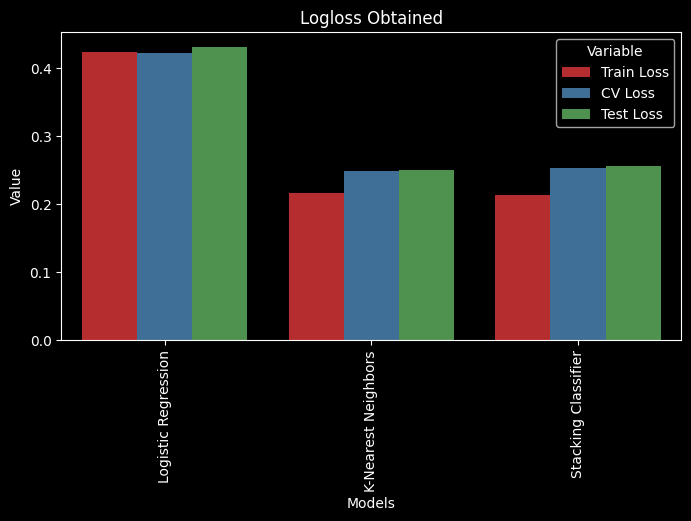

In [24]:
model_names = ['Logistic Regression',
               'K-Nearest Neighbors', 'Stacking Classifier']

tr_losses = [logreg_tr_loss, knn_tr_loss, stack_tr_loss]
cv_losses = [logreg_cv_loss, knn_cv_loss, stack_cv_loss]
te_losses = [logreg_te_loss, knn_te_loss, stack_te_loss]

summary_df = pd.DataFrame()
summary_df['Models'] = model_names
summary_df['Train Loss'] = tr_losses
summary_df['CV Loss'] = cv_losses
summary_df['Test Loss'] = te_losses

summary = tabulate(tabular_data=summary_df, headers='keys',
                   tablefmt='psql')
print(summary)

tidy = summary_df.melt(id_vars='Models').rename(columns=str.title)

plt.figure(figsize=(8, 4))
sns.barplot(data=tidy, x='Models', y='Value', hue='Variable', alpha=0.9)
plt.title(label='Logloss Obtained')
plt.xticks(rotation=90)
plt.show()